In [1]:

# =========================================== Refactored & Extended anomaly analysis pipeline =========================================== #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    silhouette_score, confusion_matrix, classification_report,
    precision_recall_fscore_support
)
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import time

sns.set(style="whitegrid")

# Like the name says, an heartbeat, to check if the system is alive
import threading, time

def heartbeat():
    while True:
        time.sleep(3600)  # 1 hour
        print("Running...")

thread = threading.Thread(target=heartbeat, daemon=True)
thread.start()

import json
from copy import deepcopy

Running...


In [2]:
# -------------------------
# 0. Config / Paths
# -------------------------
TRAIN_PATH = r'X:\Dissertacao\python_projects\dataset\ISCX-Bot-2014\ISCX_csv\Testing_file.csv'
TEST_PATH  = r'X:\Dissertacao\python_projects\dataset\ISCX-Bot-2014\ISCX_csv\Training_file.csv'
LABEL_COL = "Label"   # set to your label column name if exists, otherwise leave as-is
SAMPLE_FOR_SIL = 40000
SIL_BATCH = 40000
LOF_BATCH = 200_000
RANDOM_STATE = 42

In [3]:
# -------------------------
# 1. Load data
# -------------------------
def load_datasets(train_path, test_path):
    df_tr = pd.read_csv(train_path, encoding='ISO-8859-1')
    df_te = pd.read_csv(test_path, encoding='ISO-8859-1')
    return df_tr, df_te

df_train, df_test = load_datasets(TRAIN_PATH, TEST_PATH)

In [4]:
# -------------------------
# 2. Basic cleaning
# -------------------------
# Fill Info NaNs and drop rows missing Source/Destination
df_train['Info'].fillna("Unknown", inplace=True)
df_test['Info'].fillna("Unknown", inplace=True)
df_train.dropna(subset=['Source','Destination'], inplace=True)
df_test.dropna(subset=['Source','Destination'], inplace=True)

# Remove rows with negative Time (if that's desired)
df_train = df_train[df_train['Time'] >= 0].copy()
df_test  = df_test[df_test['Time'] >= 0].copy()

C:\Users\alexs\AppData\Local\Temp\ipykernel_12536\1138178066.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Info'].fillna("Unknown", inplace=True)
C:\Users\alexs\AppData\Local\Temp\ipykernel_12536\1138178066.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [5]:
# -------------------------
# 3. Build global mappings
# -------------------------

def build_mapping(train_col, test_col, name):
    """Create a dictionary mapping for train+test, save to JSON, return mapping."""
    all_values = pd.concat([train_col, test_col]).unique()
    mapping = {val: idx for idx, val in enumerate(all_values)}

    # optional: save for reproducibility
    with open(f"{name}_mapping.json", "w") as f:
        json.dump(mapping, f)

    return mapping

# Protocol
protocol_mapping = build_mapping(df_train['Protocol'], df_test['Protocol'], "protocol")
df_train['Protocol_enc'] = df_train['Protocol'].map(protocol_mapping).fillna(-1).astype(int)
df_test['Protocol_enc']  = df_test['Protocol'].map(protocol_mapping).fillna(-1).astype(int)

# Source
source_mapping = build_mapping(df_train['Source'], df_test['Source'], "source")
df_train['Source_enc'] = df_train['Source'].map(source_mapping).fillna(-1).astype(int)
df_test['Source_enc']  = df_test['Source'].map(source_mapping).fillna(-1).astype(int)

# Destination
dest_mapping = build_mapping(df_train['Destination'], df_test['Destination'], "destination")
df_train['Destination_enc'] = df_train['Destination'].map(dest_mapping).fillna(-1).astype(int)
df_test['Destination_enc']  = df_test['Destination'].map(dest_mapping).fillna(-1).astype(int)

# ==================== Drop originals (optional) ==================== #
# Keep only the encoded versions for modeling
df_train.drop(['Protocol', 'Source', 'Destination'], axis=1, inplace=True)
df_test.drop(['Protocol', 'Source', 'Destination'], axis=1, inplace=True)

In [6]:
# -------------------------
# 4. Feature engineering (as in your code, with small safety tweaks)
# -------------------------
def build_features(df):
    # Time diff per Source
    df['Time_Diff'] = df.groupby("Source_enc")['Time'].diff()
    # If first diff is NaN, fill with group's median diff (safer than mean)
    df['Time_Diff'] = df['Time_Diff'].fillna(df.groupby('Source_enc')['Time'].transform('median'))
    df['Time_Diff'] = df['Time_Diff'].fillna(0.0)
    # Packet rate: robust clip then packets / time span (clip prevents tiny denominators)
    def packet_rate(series):
        if len(series) < 2:
            return 0.0
        q1, q3 = np.percentile(series, [25, 75])
        iqr = max(q3 - q1, 1e-9)
        clipped = np.clip(series, q1 - 1.5 * iqr, q3 + 1.5 * iqr)
        denom = clipped.max() - clipped.min()
        denom = denom if denom > 1e-6 else 1e-6
        return len(clipped) / denom
    df['Packet_Rate'] = df.groupby('Source_enc')['Time'].transform(packet_rate)
    # Inter-arrival (rolling mean)
    df['Inter_Arrival_Time'] = df.groupby('Source_enc')['Time_Diff'].transform(lambda x: x.rolling(10, min_periods=1).mean())
    df['Inter_Arrival_Time'] = df['Inter_Arrival_Time'].clip(lower=1e-6)
    df['Burst_Rate'] = np.where(df['Inter_Arrival_Time'] > 1e-6, 1.0 / df['Inter_Arrival_Time'], 0.0)
    # Transforms
    df['Log_IATime'] = np.log1p(df['Inter_Arrival_Time'])
    df['Log_BRate']  = np.log1p(df['Burst_Rate'].clip(lower=0))
    # BoxCox requires positive. add small epsilon
    df['BoxCox_Length'] = df['Length'] + 1e-3
    df['BoxCox_Length'], _ = boxcox(df['BoxCox_Length'])
    df['BoxCox_PRate'] = df['Packet_Rate'] + 1e-6
    # BoxCox may fail if constant; guard with log1p fallback
    try:
        df['BoxCox_PRate'], _ = boxcox(df['BoxCox_PRate'])
    except Exception:
        df['BoxCox_PRate'] = np.log1p(df['Packet_Rate'])
    return df

df_train = build_features(df_train)
df_test  = build_features(df_test)

In [7]:
# -------------------------
# 5. Select features & scale (fit scaler on train, apply to test)
# -------------------------
NUM_FEATURES = ["Time_Diff", "Log_IATime", "Log_BRate", "BoxCox_Length", "BoxCox_PRate"]
scaler = MinMaxScaler()
scaler.fit(df_train[NUM_FEATURES])
df_train_scaled = pd.DataFrame(scaler.transform(df_train[NUM_FEATURES]), columns=NUM_FEATURES)
df_test_scaled  = pd.DataFrame(scaler.transform(df_test[NUM_FEATURES]), columns=NUM_FEATURES)

# Small de-duplication + tiny noise to avoid LOF duplicate issues
df_train_scaled = df_train_scaled.drop_duplicates().reset_index(drop=True)
df_test_scaled  = df_test_scaled.drop_duplicates().reset_index(drop=True)
df_train_scaled += np.random.normal(0, 1e-6, df_train_scaled.shape).astype("float32")
df_test_scaled  += np.random.normal(0, 1e-6, df_test_scaled.shape).astype("float32")

# Reduce precision to save memory
df_train_scaled = df_train_scaled.astype("float32")
df_test_scaled  = df_test_scaled.astype("float32")

# We'll keep copies of the scaled frames with indexes aligned to original for backreference:
df_train_scaled_full = df_train_scaled.copy()
df_test_scaled_full  = df_test_scaled.copy()

In [8]:
# -------------------------
# 6. Train Isolation Forest
# -------------------------
iso_forest = IsolationForest(
    n_estimators=550,
    contamination="auto",
    random_state=45,
    verbose=0)

t0 = time.time()
iso_forest.fit(df_train_scaled_full)
t1 = time.time()
print(f"IsolationForest trained in {t1-t0:.1f}s")

df_train_scaled_full["Anomaly_IForest"] = iso_forest.predict(df_train_scaled_full)
df_test_scaled_full  = df_test_scaled_full if 'df_test_scaled_full' in globals() else df_test_scaled.copy()
df_test_scaled_full["Anomaly_IForest"] = iso_forest.predict(df_test_scaled)

# Convert labels to -1/1 convention (already so)
print("IForest train anomaly DONE")

IsolationForest trained in 54.7s
IForest train anomaly %: 14.984523578719156
IForest test anomaly %:  23.5522159270729


In [9]:
# -------------------------
# 7. Batched LOF predictions (memory-friendly)
# -------------------------
lof = LocalOutlierFactor(
    n_neighbors=30,
    algorithm="ball_tree", # a usar: "ball_tree" ou "kd_tree". Algoritmos de pesquisa k-NN
    leaf_size=100, # valores mais baixos são mais preciso, mas demoram mais tempo para terminar
    contamination="auto", 
    metric="manhattan",
    #novelty=False,
    n_jobs=-1)

def lof_predict_batched(X, batch_size=LOF_BATCH, lof_model=None):
    """Return concatenated lof predictions computed per-batch.
       NOTE: LOF.fit_predict computes scores per-batch independently (no incremental LOF)."""
    if lof_model is None:
        lof_model = LocalOutlierFactor(n_neighbors=30, metric="euclidean", contamination="auto")
    n = len(X)
    y = np.zeros(n, dtype=int)
    for i in range(0, n, batch_size):
        batch = X.iloc[i:i+batch_size]
        # fit_predict returns -1 for outlier, 1 for inlier
        y[i:i+len(batch)] = lof_model.fit_predict(batch)
    return y

t0 = time.time()
y_lof_train = lof_predict_batched(df_train_scaled_full, batch_size=LOF_BATCH, lof_model=lof)
t1 = time.time()
print(f"LOF (train) batched predictions in {(t1-t0)/60:.1f}min")

y_lof_test = lof_predict_batched(df_test_scaled, batch_size=LOF_BATCH, lof_model=lof)
df_train_scaled_full["Anomaly_LOF"] = y_lof_train
df_test_scaled_full["Anomaly_LOF"] = y_lof_test

print("LOF train anomaly DONE")

LOF (train) batched predictions in 30.5min
LOF train anomaly %: 6.7384579244769744
LOF test anomaly %:  5.90883105261258


In [14]:
# -------------------------
# 8. Results
# -------------------------
def anomaly_percent(df, col):
    return (df[col] == -1).sum() / len(df) * 100

print(f"IForest train anomaly %: {anomaly_percent(df_train_scaled_full,'Anomaly_IForest')}")
print(f"IForest test anomaly %:  {anomaly_percent(df_test_scaled_full,'Anomaly_IForest')}")
print(f"LOF train anomaly %: {anomaly_percent(df_train_scaled_full,'Anomaly_LOF')}")
print(f"LOF test anomaly %:  {anomaly_percent(df_test_scaled_full,'Anomaly_LOF')}")

agreement_train = np.mean(df_train_scaled_full["Anomaly_IForest"] == df_train_scaled_full["Anomaly_LOF"]) * 100
agreement_test = np.mean(df_test_scaled_full["Anomaly_IForest"] == df_test_scaled_full["Anomaly_LOF"]) * 100
print(f"Model agreement on train: {agreement_train:.2f}%")
print(f"Model agreement on test:  {agreement_test:.2f}%")

# Silhouette (sampled batches)
def batched_silhouette(df_scaled, labels_col, batch_size=10000):
    scores = []
    for i in range(0, len(df_scaled), batch_size):
        batch = df_scaled.iloc[i:i+batch_size]
        if len(batch[labels_col].unique()) < 2: 
            continue
        score = silhouette_score(batch[NUM_FEATURES], batch[labels_col])
        scores.append(score)
    return np.mean(scores) if scores else np.nan

print("Computing silhouette scores...")
silhouette_if_train = batched_silhouette(df_train_scaled_full, "Anomaly_IForest")
silhouette_lof_train = batched_silhouette(df_train_scaled_full, "Anomaly_LOF")
silhouette_if_test = batched_silhouette(df_test_scaled_full, "Anomaly_IForest")
silhouette_lof_test = batched_silhouette(df_test_scaled_full, "Anomaly_LOF")

print(f"Silhouette IForest (train): {silhouette_if_train}")
print(f"Silhouette LOF (train): {silhouette_lof_train}")
print(f"Silhouette IForest (test): {silhouette_if_test}")
print(f"Silhouette LOF (test): {silhouette_lof_test}")

IForest train anomaly %: 14.984523578719156
IForest test anomaly %:  23.5522159270729
LOF train anomaly %: 6.7384579244769744
LOF test anomaly %:  5.90883105261258
Model agreement on train: 81.09%
Model agreement on test:  73.68%
Computing silhouette scores...
Silhouette IForest (train): 0.31160393357276917
Silhouette LOF (train): 0.08943929523229599
Silhouette IForest (test): 0.2815714180469513
Silhouette LOF (test): 0.17300133407115936


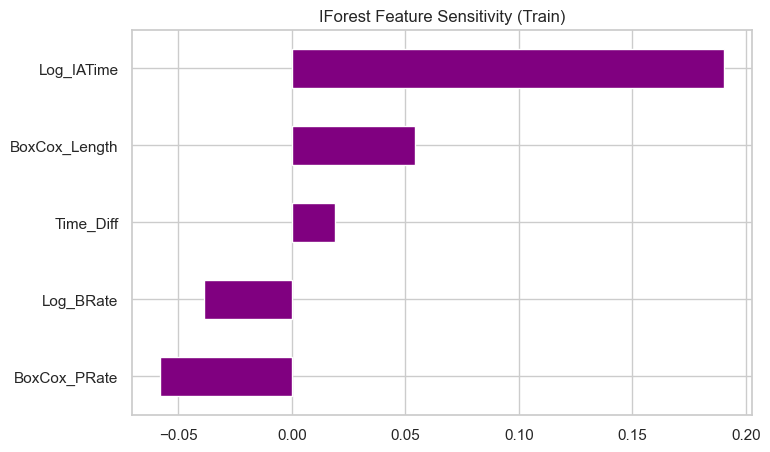

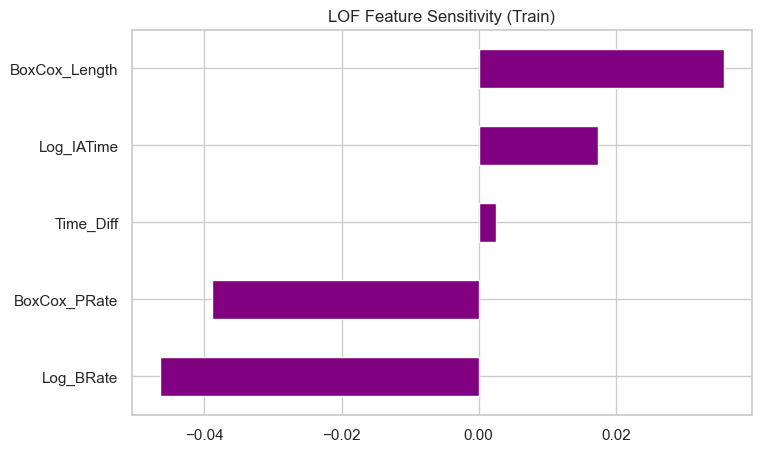

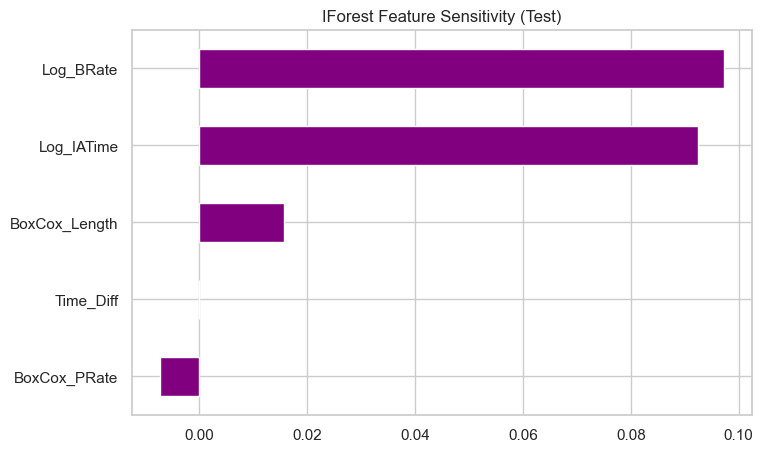

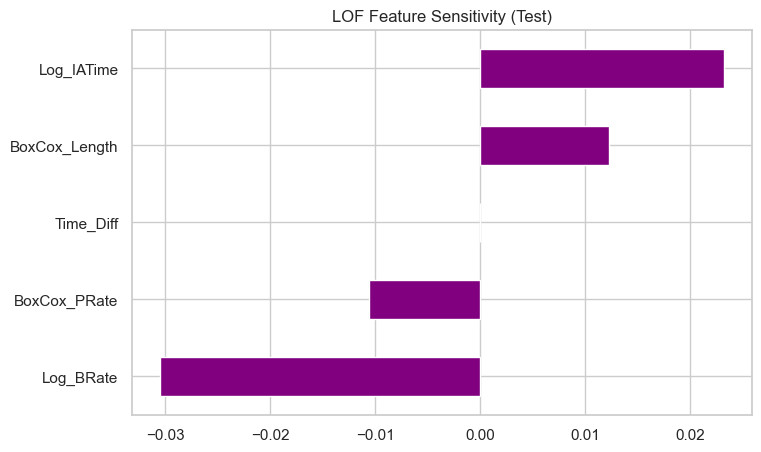

In [16]:
def feature_sensitivity(df_scaled, features, label_col):
    results = {}
    for f in features:
        mean_normal = df_scaled.loc[df_scaled[label_col]==1, f].mean()
        mean_anomaly = df_scaled.loc[df_scaled[label_col]==-1, f].mean()
        results[f] = mean_anomaly - mean_normal
    return results

fs_if_train = feature_sensitivity(df_train_scaled_full, NUM_FEATURES, "Anomaly_IForest")
fs_lof_train = feature_sensitivity(df_train_scaled_full, NUM_FEATURES, "Anomaly_LOF")
fs_if_test = feature_sensitivity(df_test_scaled_full, NUM_FEATURES, "Anomaly_IForest")
fs_lof_test = feature_sensitivity(df_test_scaled_full, NUM_FEATURES, "Anomaly_LOF")

# Bar plots
def plot_feature_sensitivity(results, title):
    plt.figure(figsize=(8,5))
    pd.Series(results).sort_values().plot(kind="barh", color="orange")
    plt.title(title)
    plt.show()

plot_feature_sensitivity(fs_if_train, "IForest Feature Sensitivity (Train)")
plot_feature_sensitivity(fs_lof_train, "LOF Feature Sensitivity (Train)")
plot_feature_sensitivity(fs_if_test, "IForest Feature Sensitivity (Test)")
plot_feature_sensitivity(fs_lof_test, "LOF Feature Sensitivity (Test)")

Plotting KDE distributions...


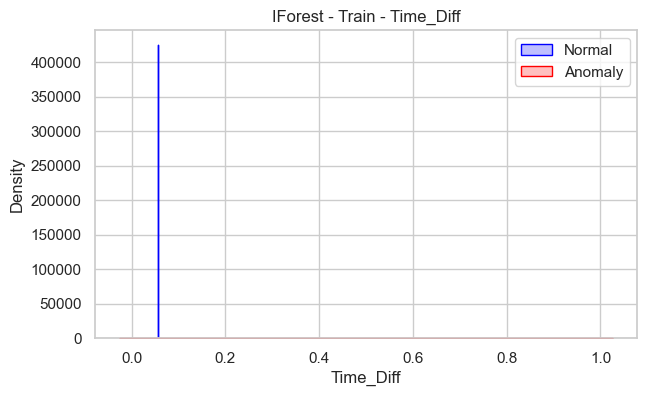

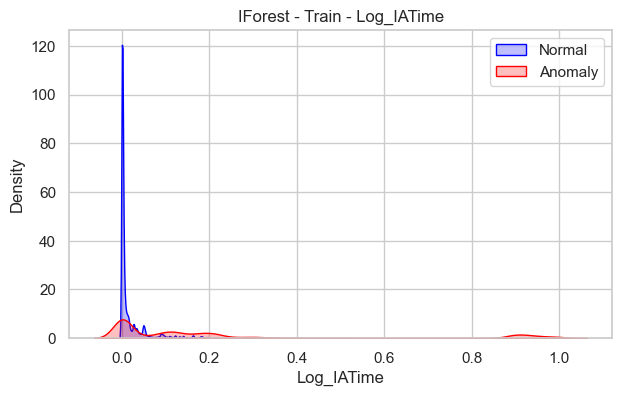

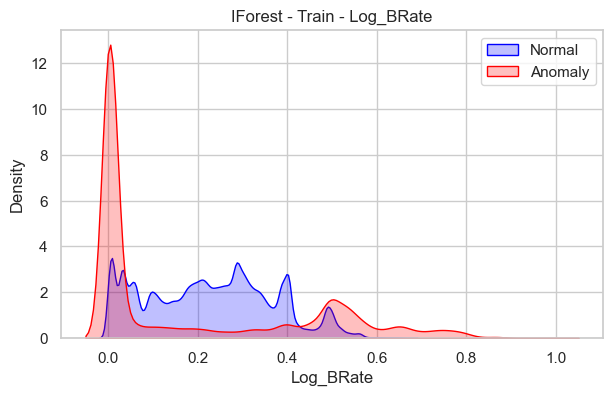

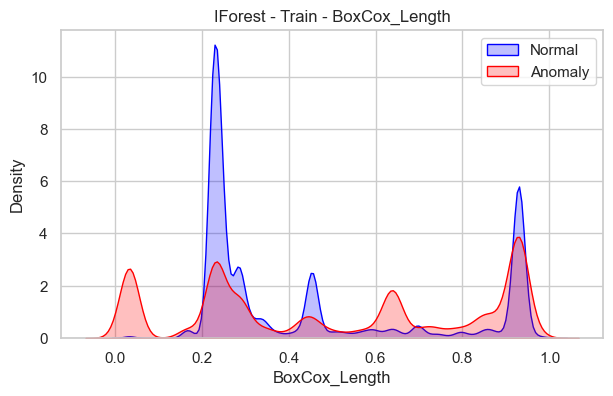

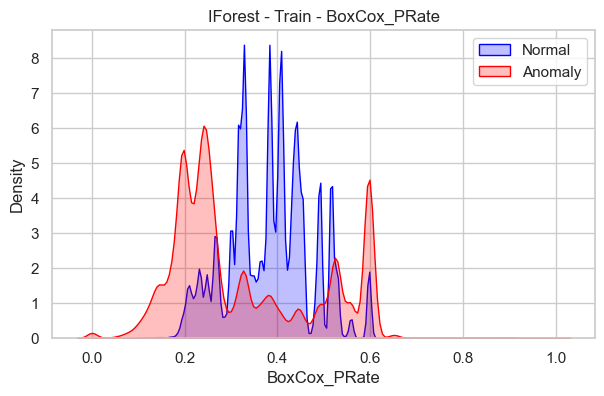

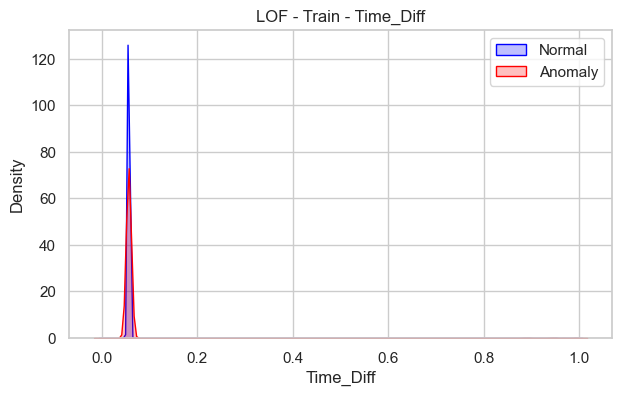

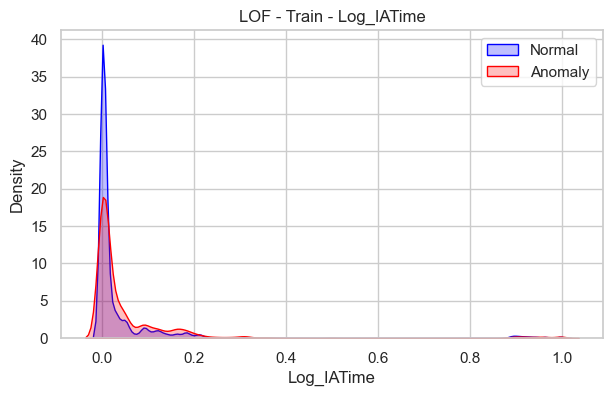

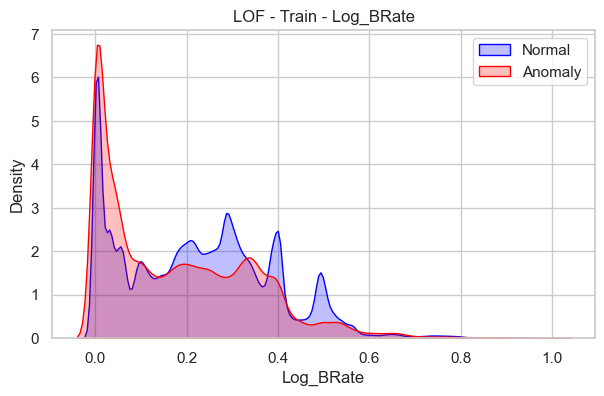

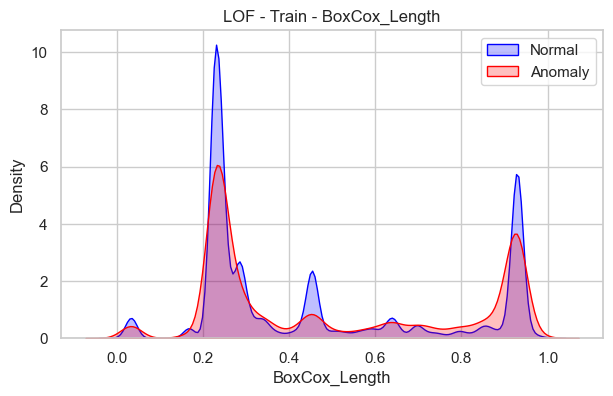

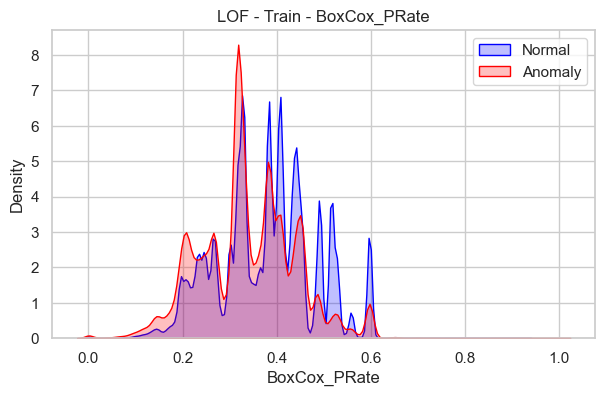

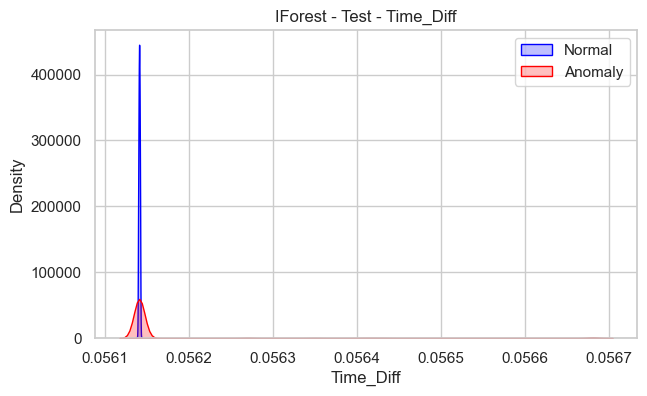

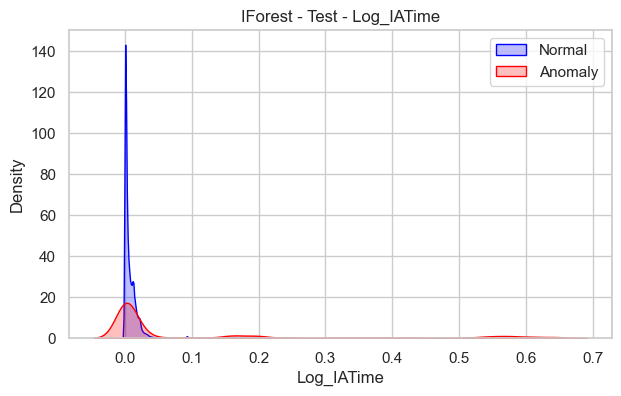

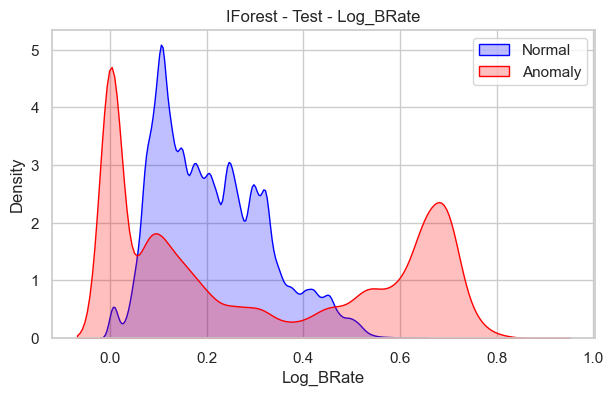

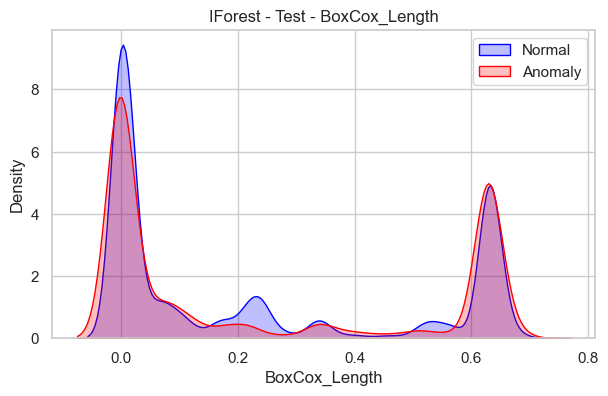

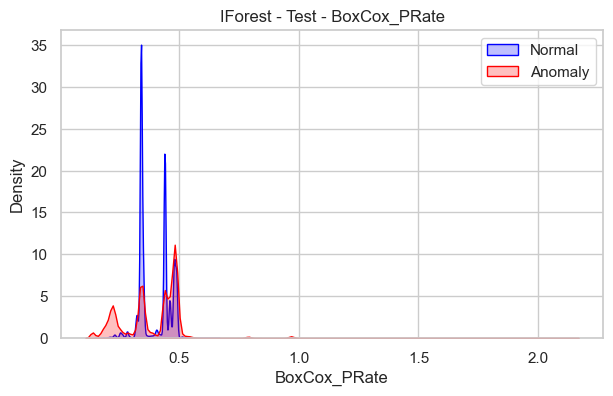

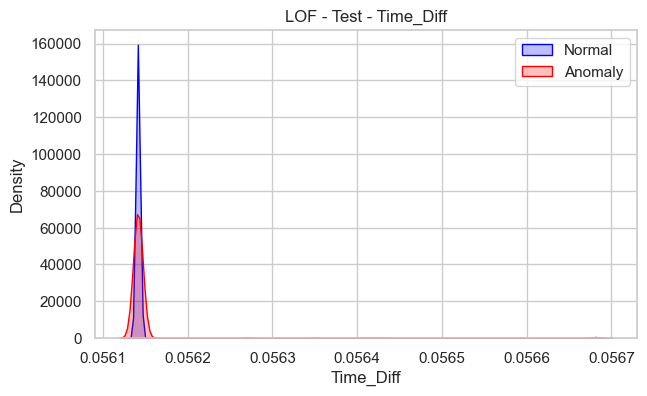

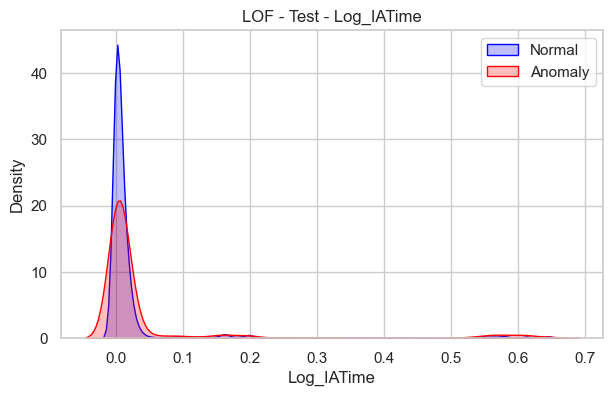

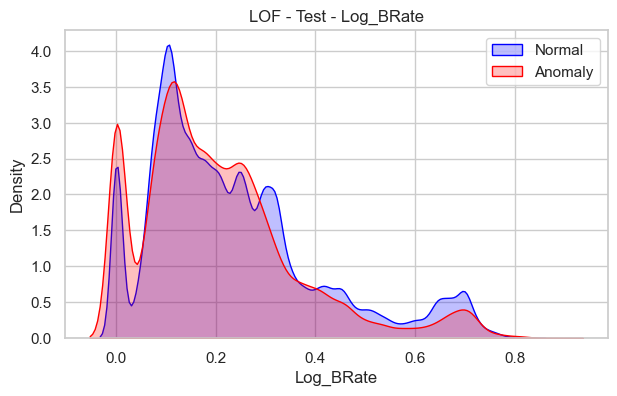

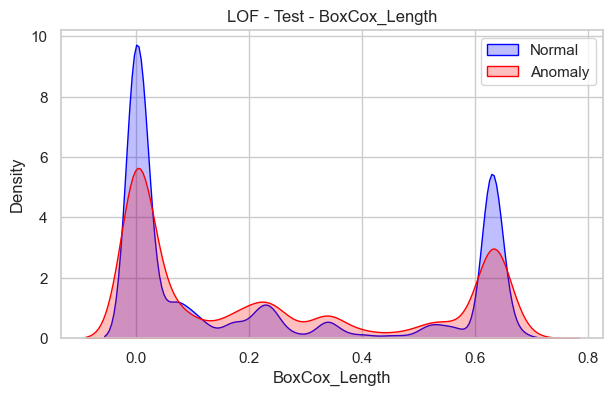

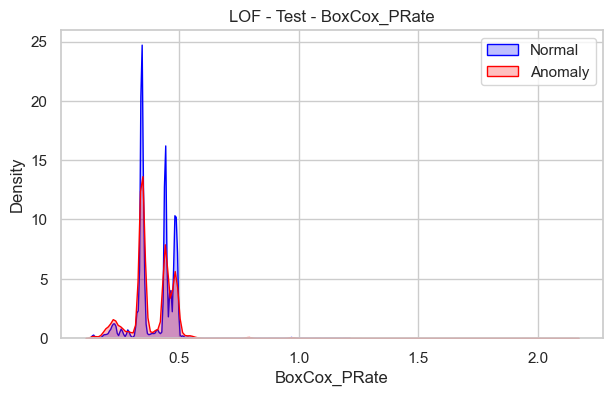

In [17]:
print("Plotting KDE distributions...")

def kde_plots(df_scaled, features, label_col, model_name, dataset_name):
    for f in features:
        plt.figure(figsize=(7,4))
        sns.kdeplot(df_scaled.loc[df_scaled[label_col]==1, f], label="Normal", color="blue", fill=True)
        sns.kdeplot(df_scaled.loc[df_scaled[label_col]==-1, f], label="Anomaly", color="red", fill=True)
        plt.title(f"{model_name} - {dataset_name} - {f}")
        plt.legend()
        plt.show()

# KDE for train
kde_plots(df_train_scaled_full, NUM_FEATURES, "Anomaly_IForest", "IForest", "Train")
kde_plots(df_train_scaled_full, NUM_FEATURES, "Anomaly_LOF", "LOF", "Train")

# KDE for test
kde_plots(df_test_scaled_full, NUM_FEATURES, "Anomaly_IForest", "IForest", "Test")
kde_plots(df_test_scaled_full, NUM_FEATURES, "Anomaly_LOF", "LOF", "Test")